---------------------------Data Preprocessing and Memory Management--------------------------
                    course_id       userid_DI  registered  viewed  explored  \
0  HarvardX/CB22x/2013_Spring  MHxPC130442623           1       0         0   
1  HarvardX/CB22x/2013_Spring  MHxPC130275857           1       0         0   
2  HarvardX/CB22x/2013_Spring  MHxPC130539455           1       1         0   
3  HarvardX/CB22x/2013_Spring  MHxPC130088379           1       1         0   
4  HarvardX/CB22x/2013_Spring  MHxPC130024894           1       1         0   

   certified final_cc_cname_DI LoE_DI  YoB gender grade start_time_DI  \
0          0     United States    NaN  NaN    NaN     0      12/19/12   
1          0     United States    NaN  NaN    NaN     0        2/8/13   
2          0            France    NaN  NaN    NaN     0        1/1/13   
3          0     United States    NaN  NaN    NaN     0       2/18/13   
4          0     United States    NaN  NaN    NaN  0.07       1/24

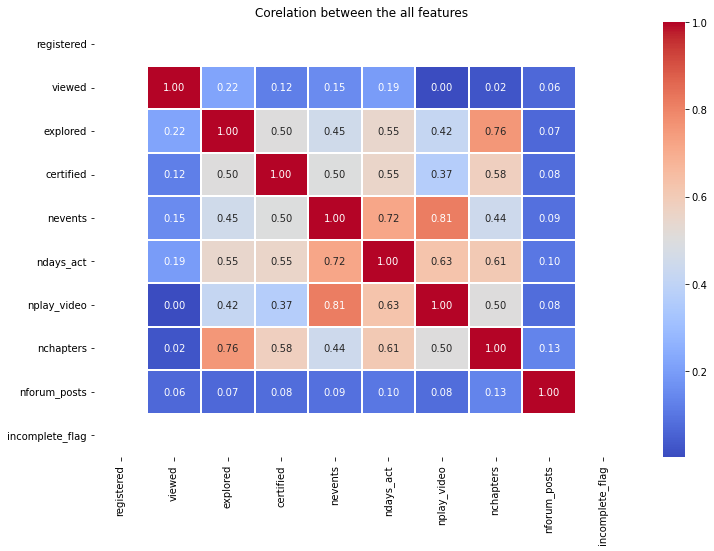

<Figure size 432x288 with 0 Axes>

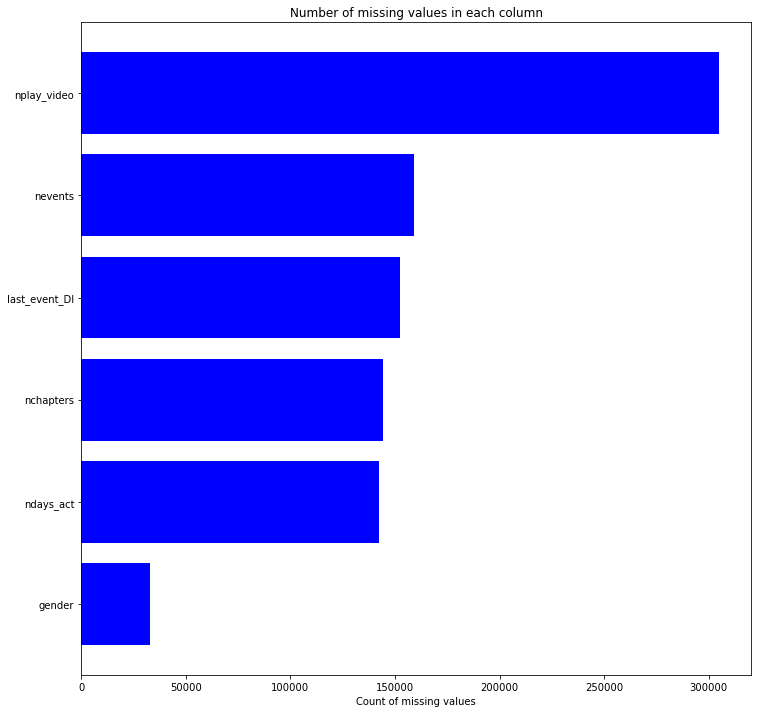

fit and transform
num of categories:  (4,)
recover the nan value
fit and transform
num of categories:  (6,)
recover the nan value
fit and transform
num of categories:  (103,)
recover the nan value
fit and transform
num of categories:  (34,)
recover the nan value
fit and transform
num of categories:  (5,)
recover the nan value


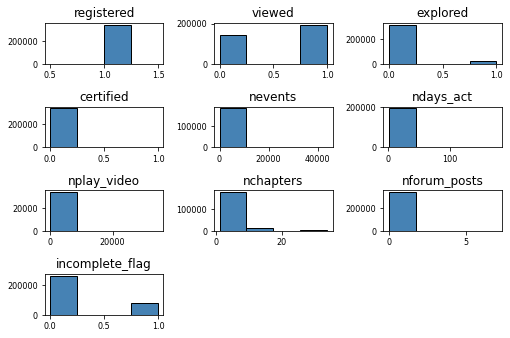

In [3]:
#import the required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Read the csv file.
df = pd.read_csv("HXPC13_DI_v3_11-13-2019.csv")

print("---------------------------Data Preprocessing and Memory Management--------------------------")

# Print the first 5 contents of csv file.
print(df.head())

print("---------------------------------------------------------------------------------------------")
#print info of the dataset and the memory usage.
print(df.info(memory_usage='deep'))

print("---------------------------------------------------------------------------------------------")
#print memory usage datatype wise.
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

print("---------------------------------------------------------------------------------------------")
#memory usage function.
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

#memory usage of ints after conversion and before conversion.
df_int = df.select_dtypes(include=['int'])

#convert int into unsigned int
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

# memory usage before conversion
print(mem_usage(df_int))

# memory usage after conversion
print(mem_usage(converted_int))
print("---------------------------------------------------------------------------------------------")
compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)
print(compare_ints)
print("---------------------------------------------------------------------------------------------")

#memory usage after conversion and before conversion.
df_float = df.select_dtypes(include=['float'])

#convert float64 into float32
converted_float = df_float.apply(pd.to_numeric,downcast='float')

# memory usage before conversion
print(mem_usage(df_float))

# memory usage after conversion
print(mem_usage(converted_float))
print("---------------------------------------------------------------------------------------------")
compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)
print(compare_floats)

#comparing the output files after reduction in memory
optimized_df = df.copy()
optimized_df[converted_int.columns] = converted_int
optimized_df[converted_float.columns] = converted_float

#initial memory usage
print("--------------------------Total Memory usage before conversion-------------------------------")
print(mem_usage(df))

#memory usage after conversion
print("--------------------------Total Memory usage after conversion--------------------------------")
print(mem_usage(optimized_df))

#memory usage of data type object
df_obj = optimized_df.select_dtypes(include=['object']).copy()
df_obj.describe()
print(df_obj.describe())

#memory usage by variable gender
gen = df_obj.gender
print(gen.head())

gen_cat = gen.astype('category')
print(gen_cat.head())

print("---------------------------------------------------------------------------------------------")
#initial memory usage
print(mem_usage(gen))
#memory usage after conversion
print(mem_usage(gen_cat))
print("---------------------------------------------------------------------------------------------")

print(gen_cat.head().cat.codes)

#conversion for all objects
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]

#initial memory usage        
print(mem_usage(df_obj))
#memory usage after conversion
print(mem_usage(converted_obj))

print("---------------------------------------------------------------------------------------------")
compare_obj = pd.concat([df_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)
print(compare_obj)
print("----------------------------Data size of Optimized DF----------------------------------------")

optimized_df[converted_obj.columns] = converted_obj
print(mem_usage(optimized_df))

print("--------------------------Data Cleaning and Imputations of missing values--------------------")

print("-----------------------------------------Optimized DF null counts----------------------------")

print(optimized_df.isnull().sum())

print("-----------------------------------------Dropping roles and YoB------------------------------")

#Drop unnecessary values
optimized_df = optimized_df.drop(['roles','YoB'],axis = 1)
X = optimized_df.copy()
print(X.head())

#Imputation of Categorical variable grade
X['grade'] = X['grade'].cat.add_categories([0])
X['grade'] = X['grade'].fillna(0)

#Imputation of Categorical Variable Level of Education
X['LoE_DI'] = X['LoE_DI'].cat.add_categories("Unknown")
X['LoE_DI'] = X['LoE_DI'].fillna("Unknown")
print(X.head())

#Identifying numerical columns to produce heatmaps
catcols = ['course_id ','userid_DI','final_cc_cname_DI','LoE_DI','gender','grade','start_time_DI','last_event_DI']
numcols = [x for x in X.columns if x not in catcols]

#plotting heatmap of numeric data
plt.figure(figsize = (12,8))
sns.heatmap(data=X[numcols].corr(),annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05)
fig = plt.gcf()
plt.title("Corelation between the all features" )
fig.savefig("Correleance_1.png")
plt.show()
plt.gcf().clear()

#Imputing missing values of flags in incomplete flags.
X['incomplete_flag'] = X['incomplete_flag'].fillna(0)

#Plot missing values and arrange in ascending order
missing_df = X.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,12))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
fig.savefig("MissingCount.png")
plt.show()

#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )
    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc



X.hist(bins=4, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 
zoningcode2int( df = X,target = 'gender' )
zoningcode2int( df = X,target = 'LoE_DI' )
zoningcode2int( df = X,target = 'grade' )
zoningcode2int( df = X,target = 'final_cc_cname_DI' )
zoningcode2int( df = X,target = 'course_id' )

file = "preprocessed_file.csv"
X.to_csv(file)
